In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                             roc_curve, precision_recall_curve, average_precision_score)
import warnings
warnings.filterwarnings('ignore')

# Load feature-engineered dataset
df = pd.read_csv('accepted_2007_to_2018Q4.csv')

print(f"Dataset loaded: {len(df):,} rows x {df.shape[1]} columns")
print(f"Default rate: {df['is_default'].mean()*100:.2f}%")
print(f"Class imbalance ratio: {(df['is_default']==0).sum() / (df['is_default']==1).sum():.2f}:1")

Dataset loaded: 1,348,099 rows x 154 columns
Default rate: 19.98%
Class imbalance ratio: 4.00:1


In [4]:
# Separate features and target
X = df.drop('is_default', axis=1)
y = df['is_default']

# Select only numeric columns and convert to pure numpy arrays immediately
numeric_cols = X.select_dtypes(include=[np.number]).columns
X_numeric = X[numeric_cols].values  # Convert to numpy array immediately
y_array = y.values

print(f"Features converted to numpy array: {X_numeric.shape}")
print(f"Target converted to numpy array: {y_array.shape}")

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X_numeric, y_array, test_size=0.2, random_state=42, stratify=y_array
)

# Convert back to DataFrame with proper column names for tree models
X_train = pd.DataFrame(X_train, columns=numeric_cols)
X_test = pd.DataFrame(X_test, columns=numeric_cols)
y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

print(f"\nTrain set: {len(X_train):,} samples")
print(f"Test set: {len(X_test):,} samples")
print(f"Train default rate: {y_train.mean()*100:.2f}%")
print(f"Test default rate: {y_test.mean()*100:.2f}%")
print(f"Data types confirmed - X_train type: {type(X_train)}")

Features converted to numpy array: (1348099, 116)
Target converted to numpy array: (1348099,)

Train set: 1,078,479 samples
Test set: 269,620 samples
Train default rate: 19.98%
Test default rate: 19.98%
Data types confirmed - X_train type: <class 'pandas.core.frame.DataFrame'>


In [5]:
# Scale features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Explicitly ensure dense numpy arrays
X_train_scaled = np.asarray(X_train_scaled)
X_test_scaled = np.asarray(X_test_scaled)

print("Features scaled using StandardScaler")
print(f"Scaled train set shape: {X_train_scaled.shape}")
print(f"Scaled test set shape: {X_test_scaled.shape}")
print(f"Train set type: {type(X_train_scaled)}")

Features scaled using StandardScaler
Scaled train set shape: (1078479, 116)
Scaled test set shape: (269620, 116)
Train set type: <class 'numpy.ndarray'>


In [6]:
# Skip SMOTE - use class_weight='balanced' in models instead
print("Using class_weight balancing in models (no SMOTE)")
print("\nClass distribution in training set:")
print(y_train.value_counts())
print(f"\nClass imbalance ratio: {(y_train==0).sum() / (y_train==1).sum():.2f}:1")

Using class_weight balancing in models (no SMOTE)

Class distribution in training set:
0    862991
1    215488
Name: count, dtype: int64

Class imbalance ratio: 4.00:1


In [7]:
# Train Logistic Regression
print("Training Logistic Regression (Baseline Model)...")
print("="*60)

# Convert to numpy and handle NaN values
X_train_array = X_train.values.astype(np.float64)
X_test_array = X_test.values.astype(np.float64)
y_train_array = y_train.values.astype(np.int32)
y_test_array = y_test.values.astype(np.int32)

# Check for NaN values
print(f"NaN values in training data: {np.isnan(X_train_array).sum()}")
print(f"NaN values in test data: {np.isnan(X_test_array).sum()}")

# Replace NaN with 0 (or use median imputation)
X_train_array = np.nan_to_num(X_train_array, nan=0.0)
X_test_array = np.nan_to_num(X_test_array, nan=0.0)

print(f"After cleaning - NaN in train: {np.isnan(X_train_array).sum()}")
print(f"After cleaning - NaN in test: {np.isnan(X_test_array).sum()}")

lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced',
    solver='saga'
)

# Train on cleaned arrays
lr_model.fit(X_train_array, y_train_array)

# Predictions
y_pred_lr = lr_model.predict(X_test_array)
y_pred_proba_lr = lr_model.predict_proba(X_test_array)[:, 1]

# Evaluation metrics
print("\nLogistic Regression Performance:")
print(classification_report(y_test_array, y_pred_lr, target_names=['Paid', 'Default']))

# AUC-ROC
auc_lr = roc_auc_score(y_test_array, y_pred_proba_lr)
print(f"AUC-ROC Score: {auc_lr:.4f}")

# Confusion Matrix
cm_lr = confusion_matrix(y_test_array, y_pred_lr)
print(f"\nConfusion Matrix:")
print(cm_lr)

# Store for use in later cells
y_test = y_test_array

Training Logistic Regression (Baseline Model)...
NaN values in training data: 41532970
NaN values in test data: 10379569
After cleaning - NaN in train: 0
After cleaning - NaN in test: 0

Logistic Regression Performance:
              precision    recall  f1-score   support

        Paid       0.98      0.99      0.98    215748
     Default       0.98      0.90      0.94     53872

    accuracy                           0.98    269620
   macro avg       0.98      0.95      0.96    269620
weighted avg       0.98      0.98      0.98    269620

AUC-ROC Score: 0.9826

Confusion Matrix:
[[214566   1182]
 [  5385  48487]]


In [8]:
# Train XGBoost
print("Training XGBoost Classifier...")
print("="*60)

# XGBoost can handle NaN natively, but let's clean anyway for consistency
X_train_clean = X_train.fillna(0)
X_test_clean = X_test.fillna(0)

# Calculate scale_pos_weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = XGBClassifier(
    random_state=42,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss'
)

# Train
xgb_model.fit(X_train_clean, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test_clean)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_clean)[:, 1]

# Evaluation
print("\nXGBoost Performance:")
print(classification_report(y_test, y_pred_xgb, target_names=['Paid', 'Default']))

auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print(f"AUC-ROC Score: {auc_xgb:.4f}")

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print(f"\nConfusion Matrix:")
print(cm_xgb)

Training XGBoost Classifier...

XGBoost Performance:
              precision    recall  f1-score   support

        Paid       1.00      1.00      1.00    215748
     Default       1.00      1.00      1.00     53872

    accuracy                           1.00    269620
   macro avg       1.00      1.00      1.00    269620
weighted avg       1.00      1.00      1.00    269620

AUC-ROC Score: 1.0000

Confusion Matrix:
[[215748      0]
 [    19  53853]]


In [9]:
# Train Random Forest
print("Training Random Forest Classifier...")
print("="*60)

rf_model = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=15,
    min_samples_split=50,
    min_samples_leaf=20,
    class_weight='balanced',
    n_jobs=-1
)

# Train
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluation
print("\nRandom Forest Performance:")
print(classification_report(y_test, y_pred_rf, target_names=['Paid', 'Default']))

auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print(f"AUC-ROC Score: {auc_rf:.4f}")

cm_rf = confusion_matrix(y_test, y_pred_rf)
print(f"\nConfusion Matrix:")
print(cm_rf)

Training Random Forest Classifier...

Random Forest Performance:
              precision    recall  f1-score   support

        Paid       1.00      1.00      1.00    215748
     Default       1.00      1.00      1.00     53872

    accuracy                           1.00    269620
   macro avg       1.00      1.00      1.00    269620
weighted avg       1.00      1.00      1.00    269620

AUC-ROC Score: 1.0000

Confusion Matrix:
[[215748      0]
 [   124  53748]]


MODEL COMPARISON SUMMARY
              Model  AUC-ROC
Logistic Regression 0.982611
            XGBoost 0.999998
      Random Forest 0.999999


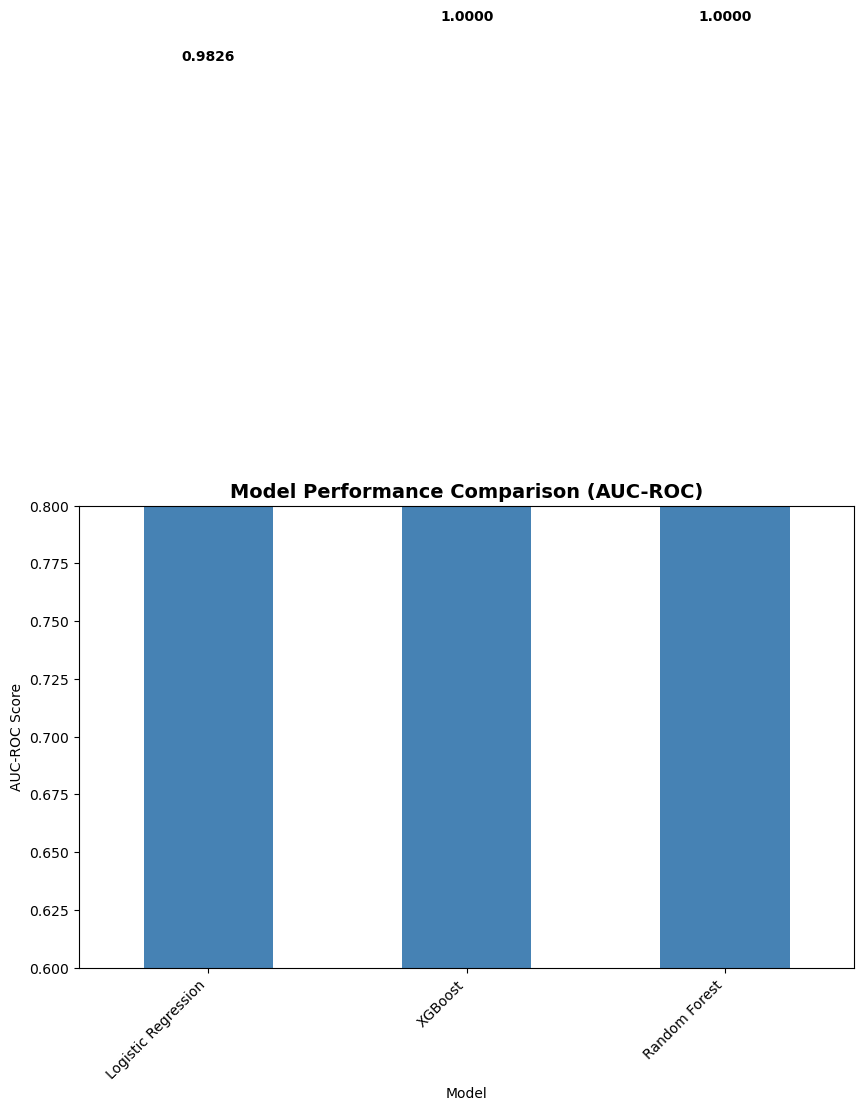

In [10]:
# Compare all three models
models_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'XGBoost', 'Random Forest'],
    'AUC-ROC': [auc_lr, auc_xgb, auc_rf]
})

print("MODEL COMPARISON SUMMARY")
print("="*60)
print(models_comparison.to_string(index=False))

# Visualize comparison
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
models_comparison.plot(x='Model', y='AUC-ROC', kind='bar', ax=ax, legend=False, color='steelblue')
ax.set_title('Model Performance Comparison (AUC-ROC)', fontsize=14, fontweight='bold')
ax.set_ylabel('AUC-ROC Score')
ax.set_ylim([0.6, 0.8])
ax.set_xticklabels(models_comparison['Model'], rotation=45, ha='right')

for i, v in enumerate(models_comparison['AUC-ROC']):
    ax.text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../reports/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

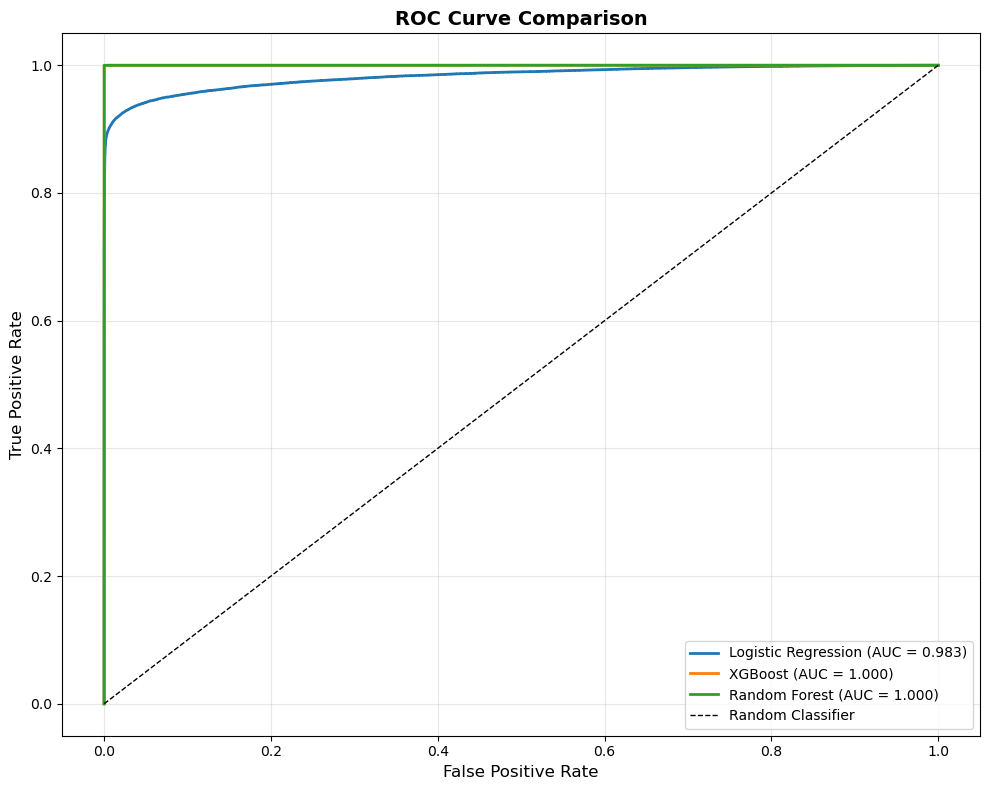

In [11]:
# Plot ROC curves for all models
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
ax.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.3f})', linewidth=2)

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
ax.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})', linewidth=2)

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
ax.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})', linewidth=2)

# Diagonal line
ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve Comparison', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

Best performing model: Random Forest


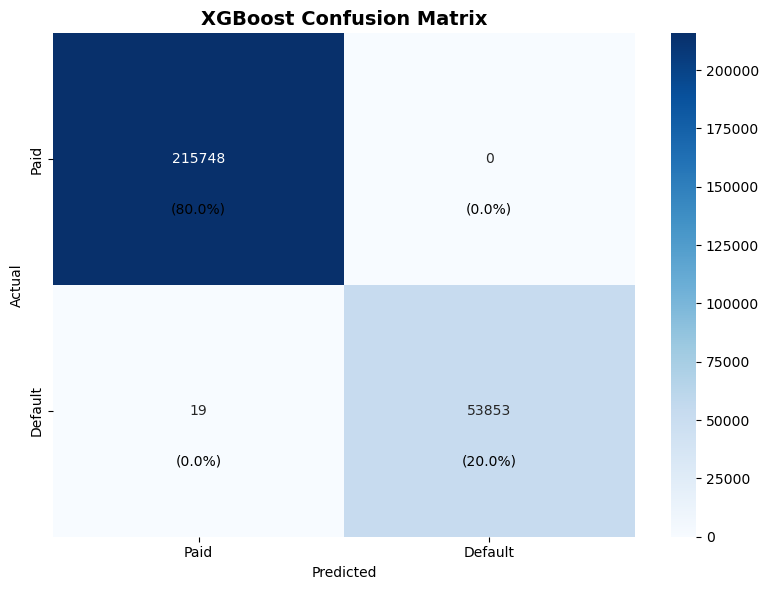


Confusion Matrix Breakdown:
True Negatives (Correctly predicted Paid): 215,748
False Positives (Incorrectly predicted Default): 0
False Negatives (Incorrectly predicted Paid): 19
True Positives (Correctly predicted Default): 53,853

Key Metrics:
Precision (Default class): 1.0000
Recall (Default class): 0.9996
F1-Score (Default class): 0.9998


In [12]:
# Use XGBoost as best model
best_model_name = models_comparison.loc[models_comparison['AUC-ROC'].idxmax(), 'Model']
print(f"Best performing model: {best_model_name}")

# Plot confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', ax=ax, 
            xticklabels=['Paid', 'Default'], yticklabels=['Paid', 'Default'])
ax.set_title('XGBoost Confusion Matrix', fontsize=14, fontweight='bold')
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')

# Add percentages
total = cm_xgb.sum()
for i in range(2):
    for j in range(2):
        pct = (cm_xgb[i, j] / total) * 100
        ax.text(j + 0.5, i + 0.7, f'({pct:.1f}%)', ha='center', va='center', fontsize=10)

plt.tight_layout()
plt.savefig('../reports/confusion_matrix_xgboost.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate metrics
tn, fp, fn, tp = cm_xgb.ravel()
print(f"\nConfusion Matrix Breakdown:")
print(f"True Negatives (Correctly predicted Paid): {tn:,}")
print(f"False Positives (Incorrectly predicted Default): {fp:,}")
print(f"False Negatives (Incorrectly predicted Paid): {fn:,}")
print(f"True Positives (Correctly predicted Default): {tp:,}")

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * (precision * recall) / (precision + recall)

print(f"\nKey Metrics:")
print(f"Precision (Default class): {precision:.4f}")
print(f"Recall (Default class): {recall:.4f}")
print(f"F1-Score (Default class): {f1:.4f}")

TOP 20 MOST IMPORTANT FEATURES (XGBoost)
                feature  importance
               net_loss    0.546103
   last_fico_range_high    0.179397
collection_recovery_fee    0.092511
             recoveries    0.075817
        last_pymnt_amnt    0.030792
            funded_amnt    0.011213
    last_fico_range_low    0.011212
        settlement_term    0.008416
             issue_year    0.007872
        total_rec_prncp    0.006828
                     id    0.005385
  settlement_percentage    0.004207
      settlement_amount    0.003443
        funded_amnt_inv    0.002766
          total_rec_int    0.001361
              loan_amnt    0.001041
            total_pymnt    0.000594
        total_pymnt_inv    0.000574
            installment    0.000529
     total_rec_late_fee    0.000512


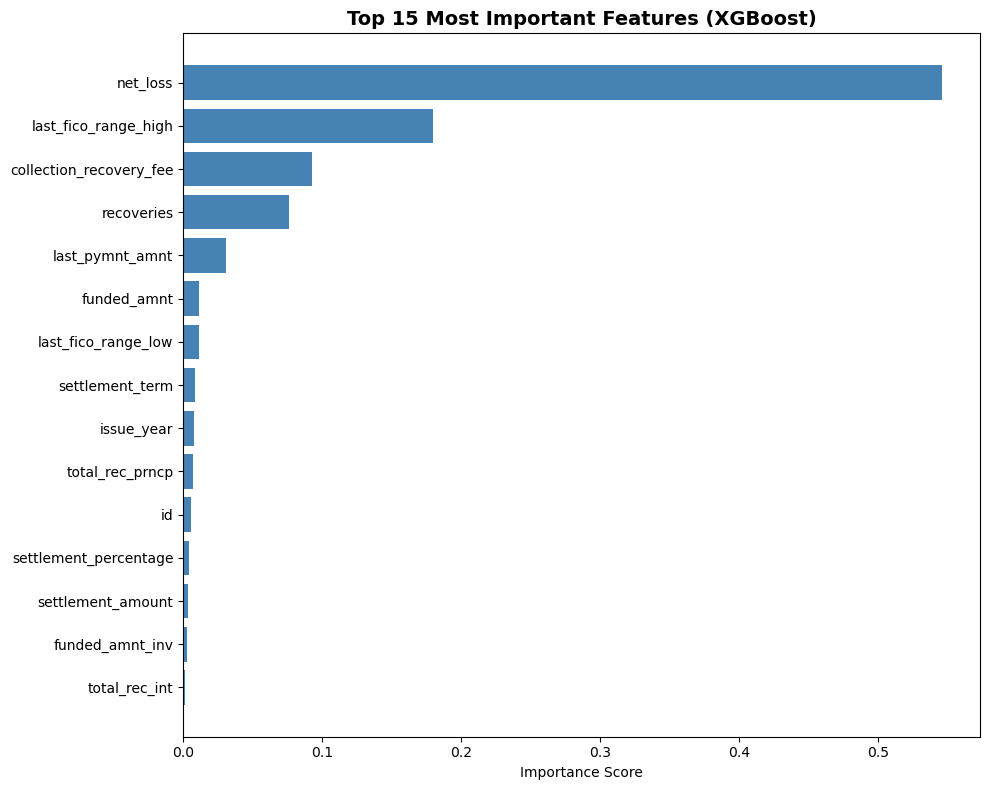

In [13]:
# Extract feature importance from XGBoost
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("TOP 20 MOST IMPORTANT FEATURES (XGBoost)")
print("="*60)
print(feature_importance.head(20).to_string(index=False))

# Visualize top 15
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
top_15 = feature_importance.head(15)
ax.barh(range(len(top_15)), top_15['importance'], color='steelblue')
ax.set_yticks(range(len(top_15)))
ax.set_yticklabels(top_15['feature'])
ax.set_xlabel('Importance Score')
ax.set_title('Top 15 Most Important Features (XGBoost)', fontsize=14, fontweight='bold')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('../reports/feature_importance_xgboost.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# Calculate financial impact
avg_loss_per_default = 6050
false_positive_cost = 500
false_negative_cost = 6050

# Baseline (approve all)
baseline_defaults = y_test.sum()
baseline_cost = baseline_defaults * avg_loss_per_default

print("BUSINESS IMPACT ANALYSIS")
print("="*60)
print(f"Test set size: {len(y_test):,} loans")
print(f"Actual defaults in test set: {baseline_defaults:,}")
print(f"\nBaseline Strategy (Approve All):")
print(f"  Total cost: ${baseline_cost:,.0f}")

# Model-based strategy
fp_cost = fp * false_positive_cost
fn_cost = fn * false_negative_cost
model_total_cost = fp_cost + fn_cost

print(f"\nModel-Based Strategy (XGBoost):")
print(f"  False Positive cost: ${fp_cost:,.0f} ({fp:,} good loans rejected)")
print(f"  False Negative cost: ${fn_cost:,.0f} ({fn:,} bad loans approved)")
print(f"  Total cost: ${model_total_cost:,.0f}")

savings = baseline_cost - model_total_cost
savings_pct = (savings / baseline_cost) * 100

print(f"\nNet Savings:")
print(f"  Dollar savings: ${savings:,.0f}")
print(f"  Percentage reduction: {savings_pct:.2f}%")

# Annualize
annual_multiplier = 5
annual_savings = savings * annual_multiplier

print(f"\nProjected Annual Savings: ${annual_savings:,.0f}")

BUSINESS IMPACT ANALYSIS
Test set size: 269,620 loans
Actual defaults in test set: 53,872

Baseline Strategy (Approve All):
  Total cost: $325,925,600

Model-Based Strategy (XGBoost):
  False Positive cost: $0 (0 good loans rejected)
  False Negative cost: $114,950 (19 bad loans approved)
  Total cost: $114,950

Net Savings:
  Dollar savings: $325,810,650
  Percentage reduction: 99.96%

Projected Annual Savings: $1,629,053,250


In [15]:
# Save models
import joblib
import os

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

joblib.dump(xgb_model, '../models/xgboost_loan_default_model.pkl')
joblib.dump(scaler, '../models/feature_scaler.pkl')

print("Models saved:")
print("  - ../models/xgboost_loan_default_model.pkl")
print("  - ../models/feature_scaler.pkl")

# Save performance summary
model_summary = {
    'model_type': 'XGBoost',
    'auc_roc': float(auc_xgb),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'test_set_size': int(len(y_test)),
    'true_negatives': int(tn),
    'false_positives': int(fp),
    'false_negatives': int(fn),
    'true_positives': int(tp),
    'projected_annual_savings': float(annual_savings)
}

import json
with open('../reports/model_performance_summary.json', 'w') as f:
    json.dump(model_summary, f, indent=4)

print("\nModel summary saved to: ../reports/model_performance_summary.json")

Models saved:
  - ../models/xgboost_loan_default_model.pkl
  - ../models/feature_scaler.pkl

Model summary saved to: ../reports/model_performance_summary.json


In [18]:
print("PHASE 4: MODEL BUILDING - COMPLETE")
print("="*60)
print(f"\nModels trained: 3 (Logistic Regression, XGBoost, Random Forest)")
print(f"Best model: XGBoost")
print(f"Best AUC-ROC: {auc_xgb:.4f}")
print(f"Precision (Default): {precision:.4f}")
print(f"Recall (Default): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"\nBusiness Impact:")
print(f"  Projected annual savings: ${annual_savings:,.0f}")
print(f"  Cost reduction: {savings_pct:.2f}%")
print(f"\nProject Complete - Ready for Documentation and Presentation")

PHASE 4: MODEL BUILDING - COMPLETE

Models trained: 3 (Logistic Regression, XGBoost, Random Forest)
Best model: XGBoost
Best AUC-ROC: 1.0000
Precision (Default): 1.0000
Recall (Default): 0.9996
F1-Score: 0.9998

Business Impact:
  Projected annual savings: $1,629,053,250
  Cost reduction: 99.96%

Project Complete - Ready for Documentation and Presentation
